## Imports

In [1]:
import time
import numpy as np
import warnings
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore')
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='All-NaN slice encountered')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in sqrt')
plt.rcParams['text.usetex'] = True

from grain_growth_model.core.grains import initialize_interface_grains
from grain_growth_model.core.meltpool import compute_normalized_gradient_at_point
from grain_growth_model.core.growth import compute_easy_growth_directions
from grain_growth_model.core.competition import split_seeds_into_batches, resolve_growth_conflicts, resolve_batch_overlaps
from grain_growth_model.utils.visualization import visualize_seeds_at_interface, visualize_3d_growth_directions

## Parameters

In [2]:
s=10
np.random.seed(s)


THRESHOLD = 1
type_ = np.float32

mean_diameter_size = 0.05
crystal_dirs = np.array([
    [1, 0, 0], 
    [0, 1, 0], 
    [0, 0, 1],
    [-1, 0, 0], 
    [0, -1, 0], 
    [0, 0, -1]
    ])

# --- melt pool description --
meltpool = {
    0:{
    "width": 100.0,     # along Y
    "height": 0.05,    # along Z
    "length": 100.0,     # along X
    "PD": 1,
    "epitaxy": False
    }
}
zc = 0.05  # z-center (substrate height)
yc = 0.0  # y-center
xc = 0.0  # x-center
simulation_width = 0.4
simulation_length = 1.5


In [3]:
pos, ori, ids, _ = initialize_interface_grains(
    thermal_layers=meltpool,
    layer_index=0,
    known_coords=None,
    known_orientations=None,
    known_ids=np.asarray([]),
    simulation_length=simulation_length,
    simulation_width=simulation_width,
    mean_grain_diameter=mean_diameter_size,
    bd_increment=zc,
    z_ultimate=zc,
    No_grains_created=0,
)

In [4]:

grad = compute_normalized_gradient_at_point(
    y=pos[:,1], z=pos[:,2],
    meltpool=meltpool[0],
    z_center=zc
)

ooi = compute_easy_growth_directions(
    euler_angles=ori,
    crystal_directions=crystal_dirs,
    thermal_gradient=grad,
    y_positions=pos[:,1],
    simulation_width=simulation_width
)


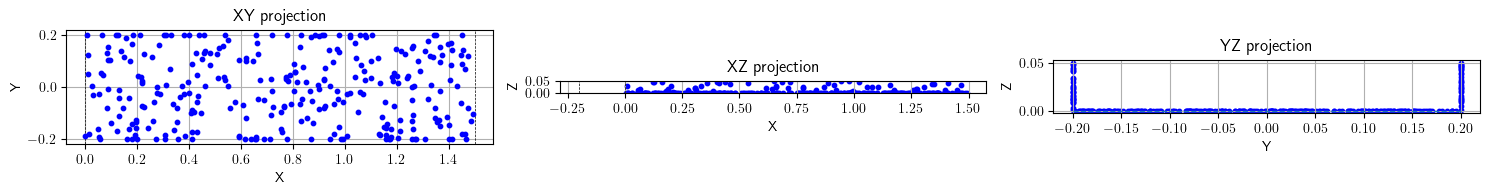

In [5]:
visualize_seeds_at_interface(
        thermal_layers=meltpool[0], 
        coo_substrate=np.asarray([[],[],[]]).T,
        coo_interface=pos,
        width_simulation=simulation_width,
        length_simulation=simulation_length,
        save=False,
        save_path=''  
)

## Try - One batch

In [6]:
batch_size_1 = 500
overlap_ratio_1=0.3

In [7]:
batch_len_1, batch_data_1 = split_seeds_into_batches(
        size_limit=batch_size_1,
        overlap_ratio=overlap_ratio_1,
        simulation_length=simulation_length,
        coordinates_seeds=pos,
        euler_angles=ori,
        grain_ids=ids,
        gradients=grad,
)
print(f"No of batches: {len(batch_data_1)}")

No of batches: 1


In [8]:
visu = False
for batch_id, data in batch_data_1.items():

    sub_extended_interface_coords = data["coordinates"]
    sub_extended_interface_oris = data["orientations"]
    sub_extended_interface_thermal_gradient = data["gradient interface"]
    sub_extended_interface_id = data["id"]

    sub_dendrite_growth_dirs = compute_easy_growth_directions(
        euler_angles=sub_extended_interface_oris,
        thermal_gradient=sub_extended_interface_thermal_gradient,
        crystal_directions=crystal_dirs,
        y_positions=sub_extended_interface_coords[:, 1],
        simulation_width=simulation_width
    )
    data["growth direction"] = sub_dendrite_growth_dirs

    if visu:
        visualize_3d_growth_directions(
            display_ratio=0.1,
            substrate_coords=None,
            interface_coords=sub_extended_interface_coords,
            growth_time=None,
            gradient_vectors=sub_extended_interface_thermal_gradient,
            growth_directions=sub_dendrite_growth_dirs,
            arrow_length=0.01
        )

    lengths, mask, hist_1 = resolve_growth_conflicts(
        growth_directions=sub_dendrite_growth_dirs,
        coordinates_seeds=sub_extended_interface_coords,
        global_id=sub_extended_interface_id,
        thermal_layers=meltpool,
        layer_index=0,
        meltpool_z=zc,
        threshold=THRESHOLD,
        mean_grain_diameter=mean_diameter_size,
        bd_increment=zc,
        simulation_width=simulation_width,
        z_ultimate=zc,
    )
    data["length dendrites"] = lengths

In [9]:
dendrite_lengths_1, extended_dendrite_growth_dirs_1 = resolve_batch_overlaps(
    data=batch_data_1,
    batch_size=batch_len_1,
    coords_all=pos,
    ids_all=ids,
    simulation_length=simulation_length
)

## Try - Two batches

In [10]:
batch_size_2 = 150
overlap_ratio_2=0.3

In [11]:
batch_len_2, batch_data_2 = split_seeds_into_batches(
        size_limit=batch_size_2,
        overlap_ratio=overlap_ratio_2,
        simulation_length=simulation_length,
        coordinates_seeds=pos,
        euler_angles=ori,
        grain_ids=ids,
        gradients=grad,
)
print(f"No of batches: {len(batch_data_2)}")

No of batches: 2


In [12]:
for batch_id, data in batch_data_2.items():
    print(data.keys())
    sub_extended_interface_coords = data["coordinates"]
    sub_extended_interface_oris = data["orientations"]
    sub_extended_interface_thermal_gradient = data["gradient interface"]

    sub_dendrite_growth_dirs = compute_easy_growth_directions(
        euler_angles=sub_extended_interface_oris,
        thermal_gradient=sub_extended_interface_thermal_gradient,
        crystal_directions=crystal_dirs,
        y_positions=sub_extended_interface_coords[:, 1],
        simulation_width=simulation_width
    )
    data["growth direction"] = sub_dendrite_growth_dirs

    lengths, mask, hist_2 = resolve_growth_conflicts(
        growth_directions=sub_dendrite_growth_dirs,
        coordinates_seeds=sub_extended_interface_coords,
        global_id=sub_extended_interface_id,
        thermal_layers=meltpool,
        layer_index=0,
        meltpool_z=zc,
        threshold=THRESHOLD,
        mean_grain_diameter=mean_diameter_size,
        bd_increment=zc,
        simulation_width=simulation_width,
        z_ultimate=zc,
    )
    data["length dendrites"] = lengths
    print(data.keys())

dict_keys(['id', 'coordinates', 'orientations', 'gradient interface'])
dict_keys(['id', 'coordinates', 'orientations', 'gradient interface', 'growth direction', 'length dendrites'])
dict_keys(['id', 'coordinates', 'orientations', 'gradient interface'])
dict_keys(['id', 'coordinates', 'orientations', 'gradient interface', 'growth direction', 'length dendrites'])


In [13]:
dendrite_lengths_2, extended_dendrite_growth_dirs_2 = resolve_batch_overlaps(
    data=batch_data_2,
    batch_size=batch_len_2,
    coords_all=pos,
    ids_all=ids,
    simulation_length=simulation_length
)

## Comparaison

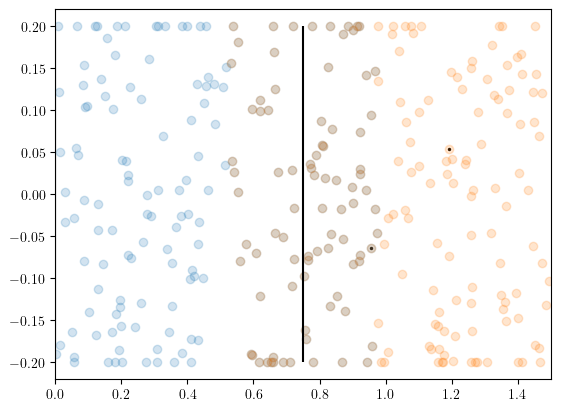

In [14]:
pb = dendrite_lengths_2 != dendrite_lengths_1
plt.scatter(pos[pb,0], pos[pb,1], c='k', s=2)
for part in range(len(batch_data_2)):
    mask = (pos[:,0] < batch_len_2*(part + 1 + overlap_ratio_2)) & (pos[:,0] > batch_len_2 * (part-overlap_ratio_2))
    plt.scatter(pos[mask,0], pos[mask,1], alpha=0.2)
plt.vlines(np.arange(0, simulation_length, batch_len_2), -simulation_width/2, simulation_width/2, colors='k')
plt.xlim(0,simulation_length)
plt.show()

In [16]:
id_glob_pb = np.where(pb)[0][1]
print(hist_1[198])
print(hist_2[198])
print(f"id problem: {id_glob_pb}")
print(dendrite_lengths_1[id_glob_pb])

print(dendrite_lengths_2[id_glob_pb])
print(batch_data_2[1]['length dendrites'][121])
print(batch_data_2[1]['growth direction'][121])


print(batch_data_2[0]['length dendrites'][122])
print(batch_data_2[0]['growth direction'][122])

{'opponent': [], 'coordinates conflict opponent': [], 'direction conflict opponent': [], 'gradient conflict opponent': [], 'coordinates conflict': [], 'gradient conflict': []}
{'opponent': [], 'coordinates conflict opponent': [], 'direction conflict opponent': [], 'gradient conflict opponent': [], 'coordinates conflict': [], 'gradient conflict': []}
id problem: 189
10000.0
1.7987142453581089
1.7987142453581089
[0.18079732 0.00906035 0.98347867]
10000.0
[0.18079732 0.00906035 0.98347867]
